## Clone repository

In [1]:
![ -d cnn_txf_bias ] || git clone https://github.com/shikhartuli/cnn_txf_bias.git
%cd cnn_txf_bias
%ls

Cloning into 'cnn_txf_bias'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 3154 (delta 16), reused 28 (delta 10), pack-reused 3113
Receiving objects: 100% (3154/3154), 176.20 MiB | 56.03 MiB/s, done.
Resolving deltas: 100% (696/696), done.
Checking out files: 100% (6009/6009), done.
/content/cnn_txf_bias
big_transfer/     COS_454_Project_Proposal.pdf  README.md  texture-vs-shape/
CNN_vs_Human.pdf  COS_454_Project_Report.pdf    simclr/    vision_transformer/
CNN_vs_Human.png  error-consistency/            tests/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import os

%cd error-consistency/raw-data_new/texture-shape_cue-conflict

/content/cnn_txf_bias/error-consistency/raw-data_new/texture-shape_cue-conflict


## Generate Human confusion matrices

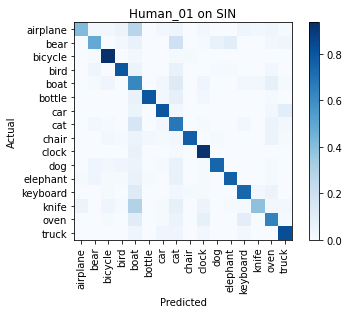

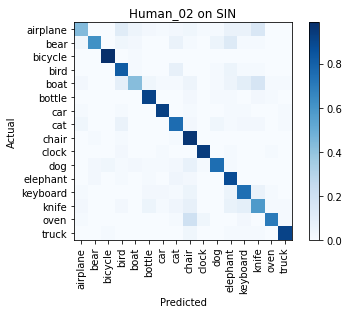

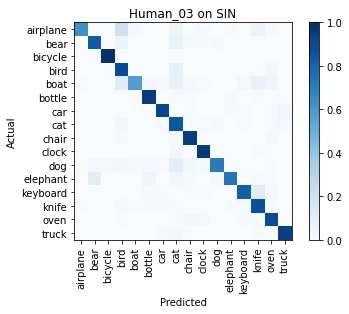

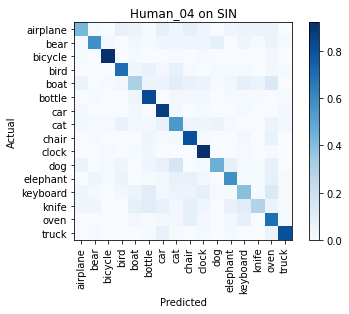

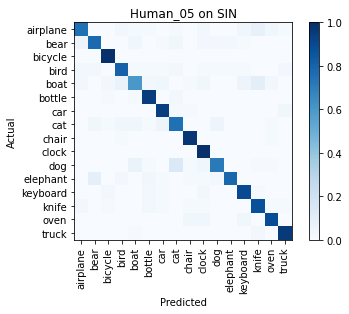

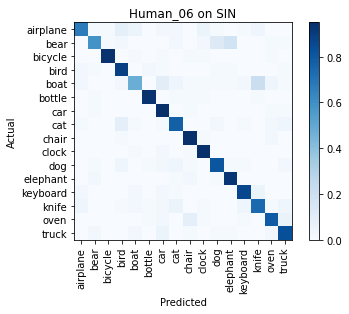

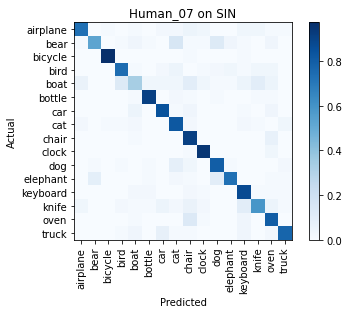

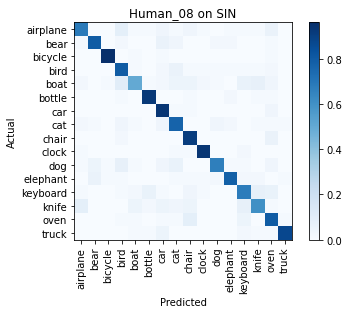

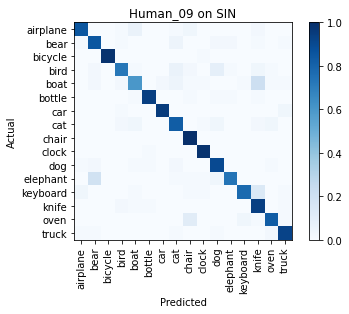

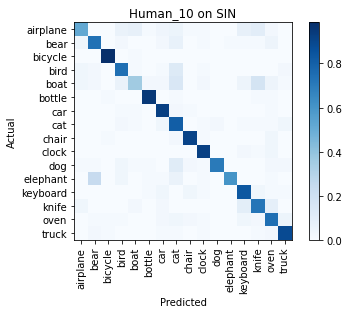

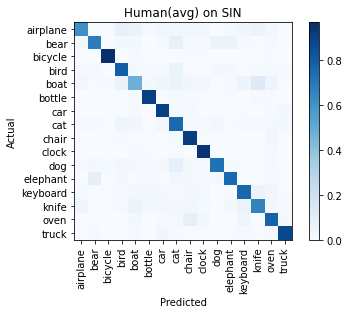

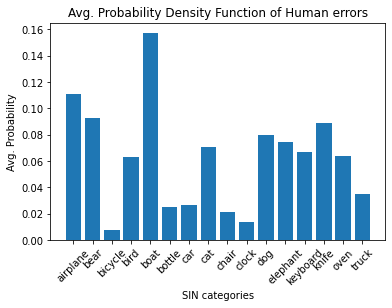

In [3]:
categories_SIN = os.listdir('../../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

pdf_list = []
cm_norm_list = []
cm_norm_dict = {}

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_cue-conflict_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)
  pdf_errors = np.sum(cm_errors, axis = 1)
  pdf_errors = np.divide(pdf_errors, np.sum(pdf_errors))
  pdf_list.append(pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues')
  plt.title(f'Human_{str_sub} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

pdf_avg = np.zeros_like(pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  pdf_avg += pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
pdf_avg = np.divide(pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on SIN')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel('SIN categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human errors')
plt.show()

## Define distance metric

In [4]:
def kl_distance(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


def cross_entropy(p, q):
	return -np.sum([p[i] * np.log(q[i]) for i in range(len(p))])

## Generate ViT confusion matrices

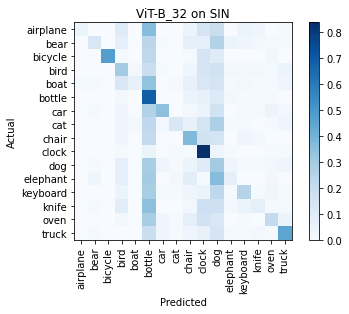

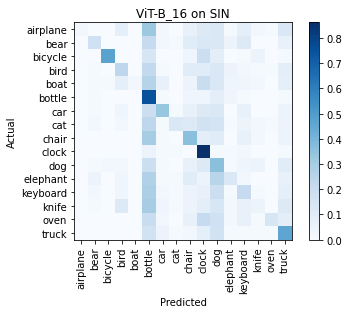

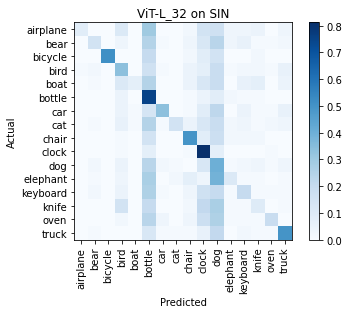

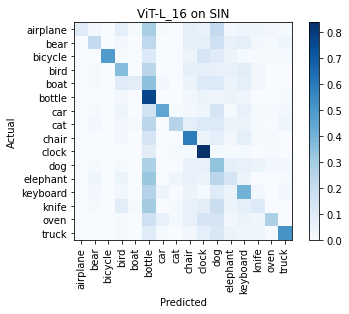

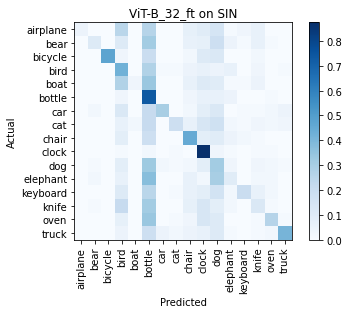

In [5]:
vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']

kl_dist = {}
ce_dist = {}
acc_SIN = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_cue-conflict_ViT-{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'B_32': cm_norm_dict[f'ViT-{model}'] = cm_norm
  if model == 'B_32_ft': cm_norm_dict[f'ViT-{model}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)
  pdf_errors = np.sum(cm_errors, axis = 1)
  pdf_errors = np.divide(pdf_errors, np.sum(pdf_errors))
  kl_dist[f'ViT-{model}'] = kl_distance(pdf_errors, pdf_avg)
  ce_dist[f'ViT-{model}'] = cross_entropy(pdf_errors, pdf_avg)
  acc_SIN[f'ViT-{model}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues')
  plt.title(f'ViT-{model} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

## Generate ResNet confusion matrices

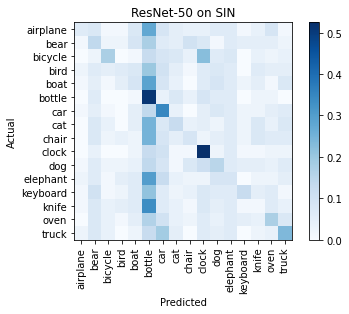

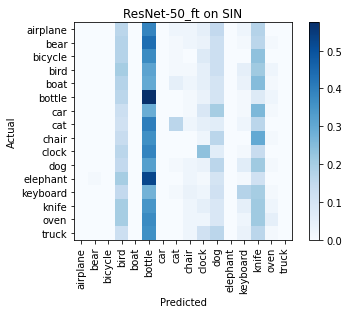

In [6]:
resnet_models = ['resnet50', 'resnet50_ft']

for model in resnet_models:
  resnet_csv = pd.read_csv(f'./texture-shape_cue-conflict_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'resnet50': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm
  if model == 'resnet50_ft': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)
  pdf_errors = np.sum(cm_errors, axis = 1)
  pdf_errors = np.divide(pdf_errors, np.amax(pdf_errors))
  kl_dist[f'ResNet-50{model[8:]}'] = kl_distance(pdf_errors, pdf_avg)
  ce_dist[f'ResNet-50{model[8:]}'] = cross_entropy(pdf_errors, pdf_avg)
  acc_SIN[f'ResNet-50{model[8:]}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues')
  plt.title(f'ResNet-50{model[8:]} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

## Plot relevant confusion matrices together

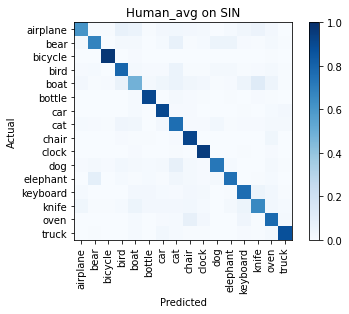

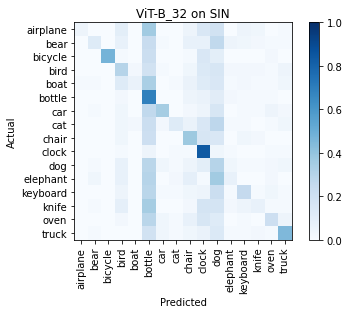

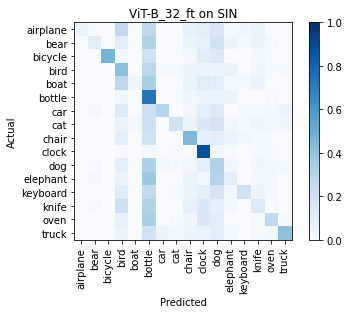

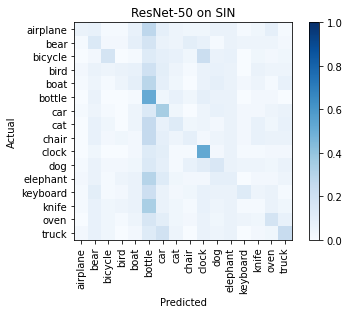

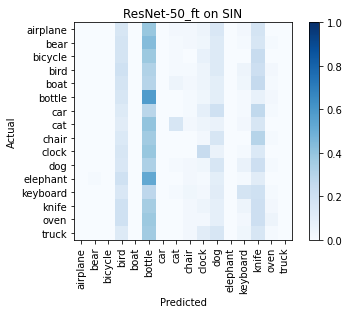

In [7]:
for model in cm_norm_dict.keys():
  
  fig, ax = plt.subplots()
  plt.imshow(cm_norm_dict[model], cmap = 'Blues', vmax = 1)
  plt.title(f'{model} on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

## Plot KL distance of model-errors

Model: ViT-B_32, 	 KL-Distance: 0.108
Model: ViT-B_16, 	 KL-Distance: 0.110
Model: ViT-L_32, 	 KL-Distance: 0.101
Model: ViT-L_16, 	 KL-Distance: 0.095
Model: ViT-B_32_ft, 	 KL-Distance: 0.109
Model: ResNet-50, 	 KL-Distance: 36.700
Model: ResNet-50_ft, 	 KL-Distance: 41.338


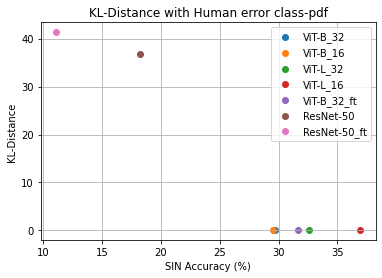

In [14]:
for model in kl_dist.keys():
  plt.scatter(acc_SIN[model]*100, kl_dist[model], label = model)
  print(f'Model: {model}, \t KL-Distance: {kl_dist[model]:0.3f}')

plt.grid()
plt.xlabel('SIN Accuracy (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human error class-pdf')
plt.legend()
plt.show()

## Plot cross-entropy of model errors

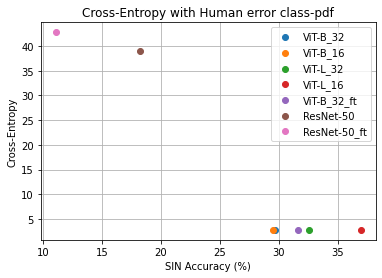

In [9]:
for model in ce_dist.keys():
  plt.scatter(acc_SIN[model]*100, ce_dist[model], label = model)

plt.grid()
plt.xlabel('SIN Accuracy (%)')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy with Human error class-pdf')
plt.legend()
plt.show()